In [12]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

df = pd.read_csv("C:\\Analisis-Morfosintactico-de-Letras-Musicales\\data\\processed\\lyrics_pos_tagged_spacy.csv")
# Load English model (make sure it's installed)
nlp = spacy.load("en_core_web_sm")

In [14]:
def extract_pos_counts(text):
    """
    Process a text with spaCy and return a dictionary with counts of various POS tags.
    """
    if not isinstance(text, str) or text.strip() == "":
        return None

    doc = nlp(text.lower())

    counts = {
        'total_words': 0,
        'verbs': 0,
        'nouns': 0,
        'adjectives': 0,
        'adverbs': 0,
        'pronouns': 0,
        'proper_nouns': 0,
        'action_verbs': 0,        # you need a list of action verb lemmas
        'relational_verbs': 0,     # you need a list of relational verb lemmas
        'present_verbs': 0,
        'gerund_verbs': 0,
        'first_person_pronouns': 0,
        'second_person_pronouns': 0,
        'third_person_pronouns': 0,
    }

    # Example lists (expand these based on your research)
    action_verbs = {'run', 'jump', 'fight', 'win', 'lose', 'dance', 'sing', 'talk', 'say', 'do'}
    relational_verbs = {'be', 'have', 'seem', 'become', 'remain', 'stay', 'appear', 'feel'}

    for token in doc:
        if token.is_punct or token.is_space:
            continue

        counts['total_words'] += 1

        # POS counts
        pos = token.pos_
        if pos == 'VERB':
            counts['verbs'] += 1
            # Check for present tense using morphological features
            if 'Tense=Pres' in token.morph:
                counts['present_verbs'] += 1
            if 'VerbForm=Ger' in token.morph:
                counts['gerund_verbs'] += 1
            # Action vs relational (by lemma)
            if token.lemma_ in action_verbs:
                counts['action_verbs'] += 1
            if token.lemma_ in relational_verbs:
                counts['relational_verbs'] += 1
        elif pos == 'NOUN':
            counts['nouns'] += 1
        elif pos == 'ADJ':
            counts['adjectives'] += 1
        elif pos == 'ADV':
            counts['adverbs'] += 1
        elif pos == 'PRON':
            counts['pronouns'] += 1
            # Person categories (simplified)
            if token.text.lower() in {'i', 'me', 'my', 'mine', 'myself', 'we', 'us', 'our', 'ours', 'ourselves'}:
                counts['first_person_pronouns'] += 1
            elif token.text.lower() in {'you', 'your', 'yours', 'yourself', 'yourselves'}:
                counts['second_person_pronouns'] += 1
            elif token.text.lower() in {'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'they', 'them', 'their', 'theirs', 'themselves'}:
                counts['third_person_pronouns'] += 1
        elif pos == 'PROPN':
            counts['proper_nouns'] += 1

    return counts

In [15]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import ast

# Initialize new columns with zeros
pos_columns = ['total_words', 'verbs', 'nouns', 'adjectives', 'adverbs', 'pronouns',
               'proper_nouns', 'action_verbs', 'relational_verbs', 'present_verbs',
               'gerund_verbs', 'first_person_pronouns', 'second_person_pronouns',
               'third_person_pronouns']

for col in pos_columns:
    df[col] = 0

# Iterate and fill
for idx, lyric in tqdm(df['Lyrics'].items(), total=len(df)):
    counts = extract_pos_counts(lyric)
    if counts:
        for col in pos_columns:
            df.at[idx, col] = counts[col]

100%|██████████| 7935/7935 [05:54<00:00, 22.40it/s]


In [16]:


# Densities per 1000 words
df['action_verbs_per1k'] = df['action_verbs'] / df['total_words'] * 1000
df['relational_verbs_per1k'] = df['relational_verbs'] / df['total_words'] * 1000
df['present_verbs_per1k'] = df['present_verbs'] / df['total_words'] * 1000
# ... similarly for other metrics

## Longitud promedio por género

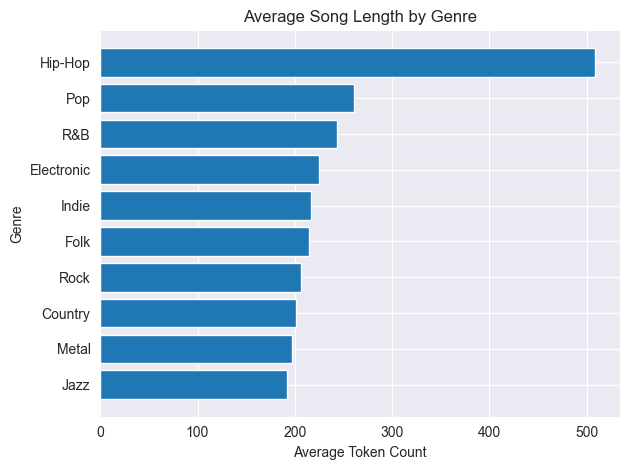

In [28]:
genre_length = df.groupby('Genre')['token_count'].mean().sort_values()

plt.figure()
plt.barh(genre_length.index, genre_length.values)
plt.xlabel("Average Token Count")
plt.ylabel("Genre")
plt.title("Average Song Length by Genre")
plt.tight_layout()
plt.show()


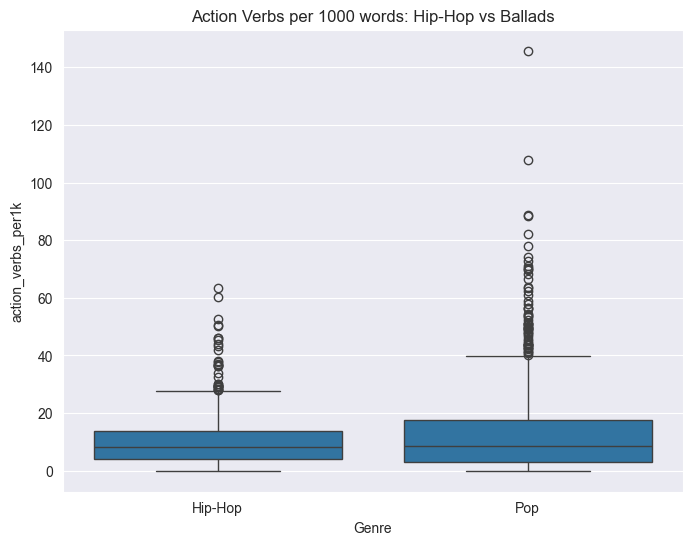

T-test: t=-5.478, p=0.000
Significant difference.


In [18]:
# Filter genres
hiphop = df[df['Genre'] == 'Hip-Hop']['action_verbs_per1k'].dropna()
ballads = df[df['Genre'] == 'Pop']['action_verbs_per1k'].dropna()

# Plot
plt.figure(figsize=(8,6))
sns.boxplot(data=df[df['Genre'].isin(['Hip-Hop', 'Pop'])], x='Genre', y='action_verbs_per1k')
plt.title('Action Verbs per 1000 words: Hip-Hop vs Ballads')
plt.show()

# T-test
t_stat, p_val = ttest_ind(hiphop, ballads, equal_var=False)
print(f"T-test: t={t_stat:.3f}, p={p_val:.3f}")
if p_val < 0.05:
    print("Significant difference.")
else:
    print("No significant difference.")

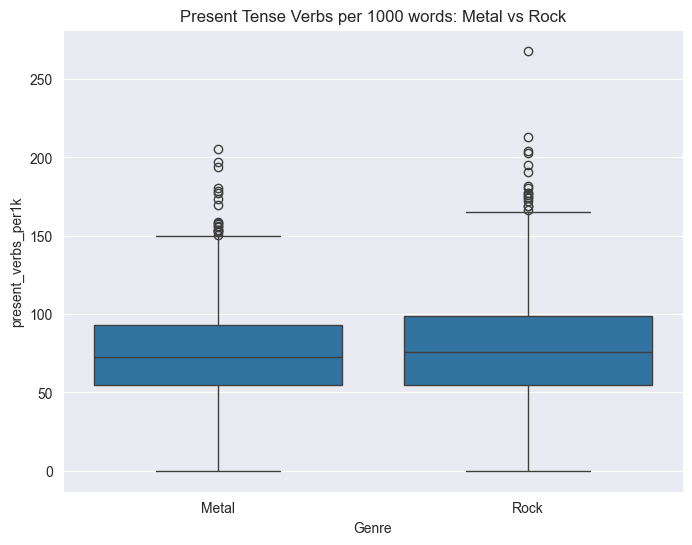

In [19]:
reggaeton = df[df['Genre'] == 'Metal']['present_verbs_per1k'].dropna()
rock = df[df['Genre'] == 'Rock']['present_verbs_per1k'].dropna()

plt.figure(figsize=(8,6))
sns.boxplot(data=df[df['Genre'].isin(['Metal', 'Rock'])], x='Genre', y='present_verbs_per1k')
plt.title('Present Tense Verbs per 1000 words: Metal vs Rock')
plt.show()



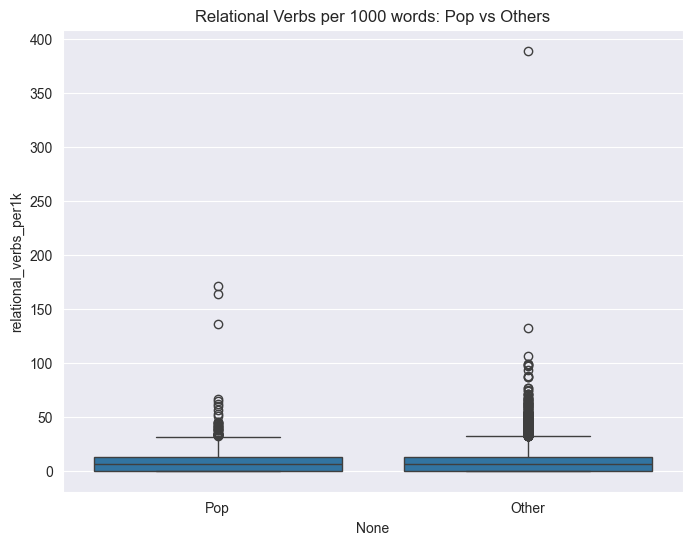

T-test: t=2.381, p=0.017


In [32]:
# Compare Pop with all other genres combined
pop = df[df['Genre'] == 'Pop']['relational_verbs_per1k'].dropna()
others = df[df['Genre'] != 'Pop']['relational_verbs_per1k'].dropna()

plt.figure(figsize=(8,6))
sns.boxplot(x=pd.Series(['Pop']*len(pop) + ['Other']*len(others)), y=pd.concat([pop, others]))
plt.title('Relational Verbs per 1000 words: Pop vs Others')
plt.show()

t_stat, p_val = ttest_ind(pop, others, equal_var=False)
print(f"T-test: t={t_stat:.3f}, p={p_val:.3f}")

## Riqueza léxica

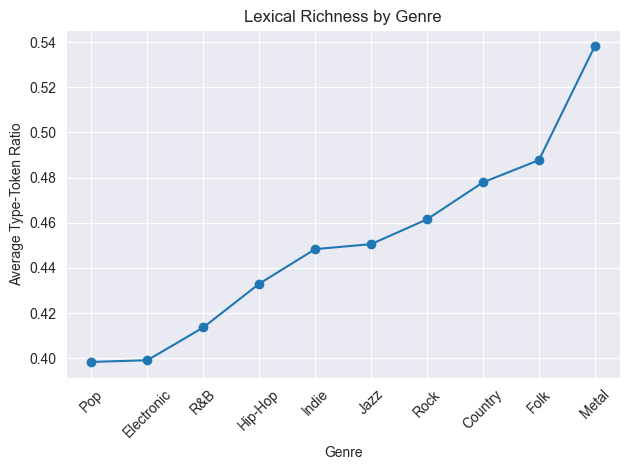

In [23]:
# Calcular riqueza léxica
df['unique_tokens'] = df['tokens_list'].apply(lambda x: len(set([t.lower() for t in x])))
df['type_token_ratio'] = df['unique_tokens'] / df['token_count']

genre_ttr = df.groupby('Genre')['type_token_ratio'].mean().sort_values()

plt.figure()
plt.plot(genre_ttr.index, genre_ttr.values, marker='o')
plt.xlabel("Genre")
plt.ylabel("Average Type-Token Ratio")
plt.title("Lexical Richness by Genre")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## Número de canciones por género

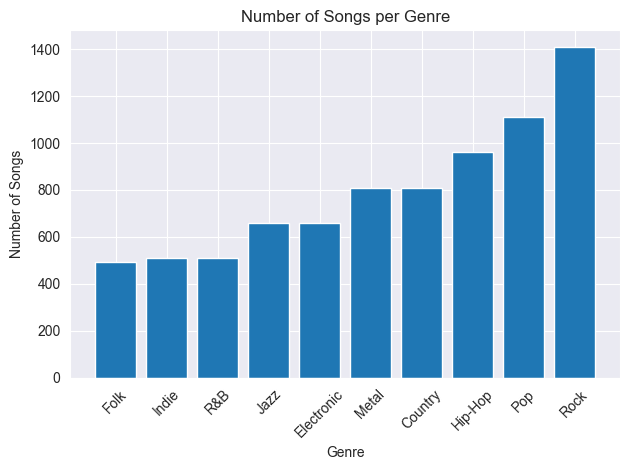

In [25]:
genre_counts = df['Genre'].value_counts().sort_values()

plt.figure()
plt.bar(genre_counts.index, genre_counts.values)
plt.xlabel("Genre")
plt.ylabel("Number of Songs")
plt.title("Number of Songs per Genre")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Longitud vs Riqueza léxica

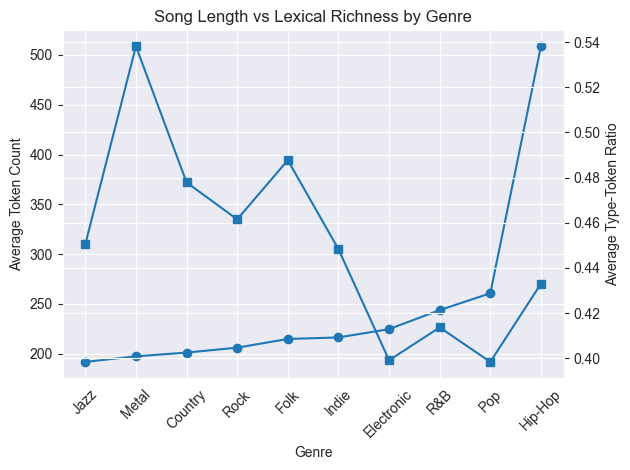

In [30]:
genre_summary = df.groupby('Genre').agg(
    avg_token_count=('token_count', 'mean'),
    avg_type_token_ratio=('type_token_ratio', 'mean')
).sort_values('avg_token_count')

fig, ax1 = plt.subplots()

ax1.plot(
    genre_summary.index,
    genre_summary['avg_token_count'],
    marker='o'
)
ax1.set_xlabel("Genre")
ax1.set_ylabel("Average Token Count")
ax1.tick_params(axis='x', rotation=45)


ax2 = ax1.twinx()
ax2.plot(
    genre_summary.index,
    genre_summary['avg_type_token_ratio'],
    marker='s'
)
ax2.set_ylabel("Average Type-Token Ratio")

plt.title("Song Length vs Lexical Richness by Genre")
plt.tight_layout()
plt.show()

